In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from torch.optim import SGD

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['text.usetex'] = True

In [3]:
class ToyModel(nn.Module):
    def __init__(self, n_dims=3, max_diag_norm=1, max_final_l2_norm=1):
        super(ToyModel, self).__init__()
        self.max_diag_norm = max_diag_norm
        self.max_final_l2_norm = max_final_l2_norm
        a = self.normalize(torch.ones((1,n_dims)))
        W = torch.normal(mean=torch.zeros(n_dims, n_dims), std=torch.ones(n_dims, n_dims))
        self.a = nn.parameter.Parameter(a)
        self.W = nn.parameter.Parameter(W)
        self.normalize_W()
    
    def normalize(self, in_):
        in_ = torch.exp(in_)
        in_ = (in_ / in_.sum() ) * self.max_diag_norm
        return in_

    def normalize_W(self):
        with torch.no_grad():
            norm_ratio = self.max_final_l2_norm / self.W.norm()
            self.W.data.copy_(self.W * norm_ratio)
    
    def post_back(self):
        self.normalize_W()
    
    def forward(self, input_):
        a_ = self.normalize(self.a)
        act_ = input_ * a_
        pred_ = act_.matmul(self.W)
        return pred_
    
    def loss(self, pred, ys):
        return 0.5 * ((pred - ys)**2).mean()

In [4]:
def train_model(model, in_data, val_data, test_data, h_params, print_every=50):
    test_x, test_y = test_data
    train_x, train_y = in_data
    val_x, val_y = val_data
    optim = SGD(model.parameters(), lr=h_params['lr'])
    min_val = float('inf')
    best_cache = [None, None]
    for epoch_ in range(h_params['n_epochs']):
        perm = np.random.permutation(train_x.shape[0])
        for i_ in range(len(perm)//h_params['bsz']):
            idxs = perm[(i_ * h_params['bsz']) : ((i_ + 1) * h_params['bsz'])]
            loss = model.loss(model(train_x[idxs]), train_y[idxs])
            loss.backward()
            optim.step()
            optim.zero_grad()
            model.post_back()
        if ((epoch_ + 1) % print_every) == 0:
            print('Epoch [{}] Train Loss = {:.3f}'.format(epoch_, loss))
        with torch.no_grad():
            val_pred = model(val_x)
            val_loss = model.loss(val_pred, val_y)
            if val_loss < min_val:
                test_pred = model(test_x)
                test_loss = model.loss(test_pred, test_y)
                if ((epoch_ + 1) % print_every) == 0:
                    print('Epoch [{}] Test Loss = {:.3f}, Val Loss = {:.3f}'.format(epoch_, test_loss, val_loss))
                    print('\n')
                min_val = val_loss
                best_cache[0] = epoch_, test_loss
                best_cache[1] = model.normalize(model.a).detach()
            
    print('Best Epoch was : ',  best_cache[0])
    return best_cache[1]

In [5]:
def generate_data(num_samples, a_y_corr, s_c, s_s, core_dim=5, spur_dim=2):
    _ys = (np.random.uniform(size=(num_samples, 1)) > 0.5)*1.0
    _ys = 2*_ys - 1
    mask_ = (np.random.uniform(size=(num_samples, 1)) < a_y_corr)*1.0
    mask_ = 2*mask_ - 1
    _as = (_ys * 1.0) * mask_

    _ys = np.repeat(_ys, core_dim, axis=1)
    _as = np.repeat(_as, spur_dim, axis=1)
    
    x_c = np.random.normal(loc=_ys, scale=s_c)
    x_s = np.random.normal(loc=_as, scale=s_s)
    return torch.FloatTensor(np.hstack([x_c, x_s]))

def noise_data(dataset, mean=0, std=1):
    noise = np.random.normal(loc=mean, scale=std, size=dataset.shape)
    return torch.FloatTensor(noise) + dataset

In [6]:
core_dim=3
spur_dim=3
corr = 0.95
s_c = 2.0
s_s = 0.5
train_data = generate_data(1000, corr, s_c, s_s, core_dim=core_dim, spur_dim=spur_dim)
noised_train = noise_data(train_data)
val_data = generate_data(100, corr, s_c, s_s, core_dim=core_dim, spur_dim=spur_dim)
noised_val = noise_data(val_data)
test_data = generate_data(100, 0.5, s_c, s_s, core_dim=core_dim, spur_dim=spur_dim)
noised_test = noise_data(test_data)

In [7]:
hp_list = [
    {
        'n_epochs' : 1000,
        'lr': 1.0,
        'bsz': 256,
    },
    {
        'n_epochs' : 1000,
        'lr': 1.0,
        'bsz': 128,
    },
    {
        'n_epochs' : 1000,
        'lr': 1.0,
        'bsz': 32,
    },
    {
        'n_epochs' : 3000,
        'lr': 1e-1,
        'bsz': 256,
    },
    {
        'n_epochs' : 3000,
        'lr': 1e-1,
        'bsz': 128,
    },
    {
        'n_epochs' : 3000,
        'lr': 1e-1,
        'bsz': 64,
    },
    {
        'n_epochs' : 3000,
        'lr': 1e-2,
        'bsz': 256,
    },
    {
        'n_epochs' : 3000,
        'lr': 1e-2,
        'bsz': 128,
    },
    {
        'n_epochs' : 3000,
        'lr': 1e-2,
        'bsz': 64,
    }
]

aggregate_info = []
diag_norms = [1e-1, 0.5, 1, 10, 20]
for diag_norm in diag_norms:
    intermed_agg = []
    for h_params in hp_list:
        model = ToyModel(n_dims=(spur_dim + core_dim), max_diag_norm=diag_norm)
        diag_weights = train_model(model, (noised_train, train_data), (noised_val, val_data), (noised_test, test_data), h_params, print_every=5000)
        core_weights, spur_weights = diag_weights[0, :core_dim], diag_weights[0, -spur_dim:]
        print('Core weights : ', core_weights)
        print('Spur weights : ', spur_weights)
        intermed_agg.append(spur_weights.max() / core_weights.min())
    print('Norm = {:.2f}. Ratios = [{}]'.format(diag_norm, ','.join(['{:.3f}'.format(x) for x in intermed_agg])))
    aggregate_info.append([intermed_agg])

Best Epoch was :  (972, tensor(1.2913))
Core weights :  tensor([9.2295e-05, 9.9610e-02, 9.0724e-05])
Spur weights :  tensor([7.0042e-05, 6.8600e-05, 6.8637e-05])
Best Epoch was :  (976, tensor(1.2925))
Core weights :  tensor([3.8166e-05, 3.5558e-05, 9.9840e-02])
Spur weights :  tensor([2.8437e-05, 2.9270e-05, 2.8631e-05])
Best Epoch was :  (895, tensor(1.2910))
Core weights :  tensor([8.3466e-06, 9.9962e-02, 8.3571e-06])
Spur weights :  tensor([6.9553e-06, 6.9496e-06, 6.9318e-06])
Best Epoch was :  (2991, tensor(1.2934))
Core weights :  tensor([0.0005, 0.0008, 0.0979])
Spur weights :  tensor([0.0003, 0.0003, 0.0003])
Best Epoch was :  (2980, tensor(1.2926))
Core weights :  tensor([0.0002, 0.0001, 0.0994])
Spur weights :  tensor([9.9285e-05, 9.8819e-05, 1.0194e-04])
Best Epoch was :  (2956, tensor(1.2924))
Core weights :  tensor([7.0610e-05, 6.0971e-05, 9.9743e-02])
Spur weights :  tensor([4.1362e-05, 4.1502e-05, 4.2123e-05])
Best Epoch was :  (2999, tensor(1.3299))
Core weights :  tens

In [8]:
this_aggregate_info = np.log(np.clip(torch.tensor(aggregate_info).squeeze().numpy(), a_min=0, a_max=100))

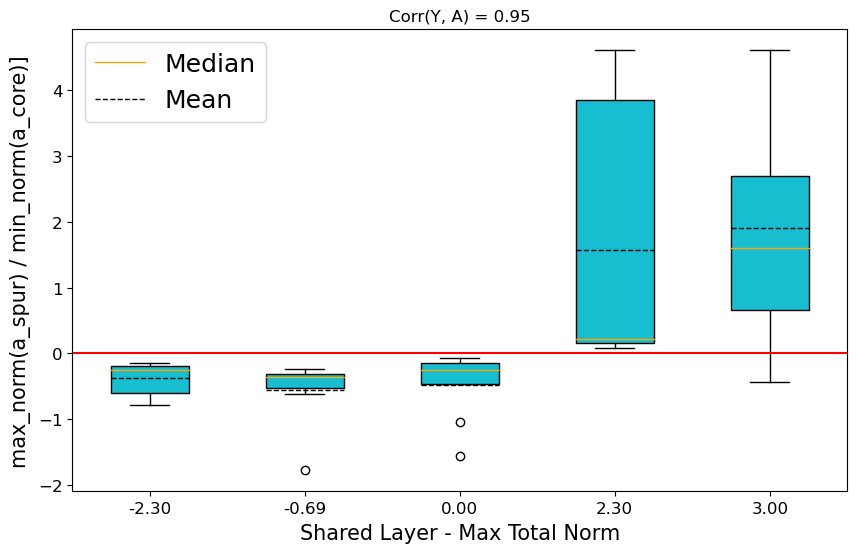

In [9]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['text.usetex'] = False
plt.figure(figsize=(10,6))
bbox = plt.boxplot([this_aggregate_info[i, :] for i in range(this_aggregate_info.shape[0])],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     showmeans=True,
                     meanline=True,
                     meanprops={'linewidth': 1, 'color': 'black'},
                     medianprops={'linewidth': 1, 'color': 'orange'},
                     widths=0.5,
                     labels=['{:.2f}'.format(np.log(x)) for x in diag_norms])  # will be used to label x-ticks
colors = ['tab:cyan']*len(bbox['boxes'])
for patch, color in zip(bbox['boxes'], colors):
    patch.set_facecolor(color)
plt.axhline(y = 0.0, color = 'r', linestyle = '-', label='Equal') 
plt.xticks([x + 1 for x in range(len(diag_norms))], ['{:.2f}'.format(np.log(x)) for x in diag_norms], fontsize=12)
plt.yticks(fontsize=12)
plt.title('Corr(Y, A) = {}'.format(corr))
plt.xlabel('Shared Layer - Max Total Norm', wrap=True, fontsize=15, labelpad=5)
plt.ylabel('max_norm(a_spur) / min_norm(a_core)]', wrap=True, fontsize=15, labelpad=5)
plt.legend([bbox["medians"][0], bbox["means"][0]], ['Median', 'Mean'], fontsize=18)
plt.savefig('corr=high_sc=0.5_ss=0.5.png', dpi=600)
plt.show()